# [Work in Progress] Análise - Dataset de pedidos da Olist

## 0. Overview

Este notebook traz a análise dos dados presentes no dataset de pedidos fornecido pela Olist, uma plataforma de vendas no ambiente digital que tem por objetivo empoderar pequenos, médios e grandes empreendedores. A Olist fica responsável por manter os produtos dos clientes nos marketplaces e também pela entrega dos produtos, oferecendo, também, soluções para garantir a competitividade dos clientes no ecommerce. Em resumo, quando o consumidor acessa a página de um produto de um clinte da Olist em algum marketplace, o nome da Olist irá aparecer lá.

A receita da Olist vem, em boa parte, por meio da assinatura de planos que estabelecem a relação entre ela e o cliente. Auxiliando na precificação, análise de competitividade, presença online e logística, a Olist cobra um preço fixo mensal e uma taxa de comissão por produto vendido. Desse modo, o aumento da receita da Olist depende da quantidade de clientes ativos e da receita proveniente de anúncios da Olist de cada um deles.

Dado o modelo de negócio da empresa, alguns pontos podem ser levantados:

- **A reputação da Olist nos marketplaces é fundamental para sua receita.** Por exemplo, caso um cliente grande passe a enviar produtos que tragam avaliações ruins, a pontuação da Olist nos marketplaces poderá ser comprometida, o que pode afetar as vendas e afastar possíveis clientes, afetando sua receita.
- **A Olist precisa usar os dados que possui para melhorar não só sua estratégia, mas também a dos seus clientes.** Aproveitar o máximo do potencial de cada cliente pode auxiliar na retenção e também afeta diretamente a receita da empresa.
- **O custo de aquisição de clientes possivelmente é alto, de modo que minimizar o churn é essencial.** No geral, o custo de aquisição de um cliente é substancialmente maior do que o custo de retenção. O tempo e esforço necessários para adquirir um cliente, fazer os trâmites legais, lidar com a burocracia e colocar seus produtos no marketplace devem ser valorizados, e a retenção de clientes precisa ser alta.

## 1. Dataset

O dataset está disponível no [Kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) e consiste em cerca de 100000 pedidos feitos entre 2016 e 2018. Os dados estão em tabelas separadas, que trazem informações sobre os pedidos em si, a composição de produtos desses pedidos, os produtos, os clientes e sua localização, a avaliação dos pedidos e os vendedores. O dataset foi disponibilidade pelo Olist na plataforma, de modo que os dados possuem alta integridade.

O esquema dos dados está disponível no Kaggle e a modelagem utilizada nas análises irá dependender do seu objetivo.

## 2. Objetivo

O objetivo da análise é:

- Entender o que causa uma má avaliação de um pedido.
- Entender clientes problemáticos e clientes churn.
- Segmentar os consumidores da Olist em geral quanto às suas preferências de compra (categorias de produto, ticket médio, etc) e sua localização com o intuito de verificar potenciais clientes para loyalty.
- Segmentar os consumidores de grandes clientes da Olist com o mesmo intuito.
- Buscar clientes churn da Olist e entender possíveis causas.

## 3. Análise dos Pedidos mal avaliados

Para cada pedido registrado há uma avaliação atrelada que contém, ao menos, uma nota de 1 a 5, podendo conter, também, um comentário. A existência de uma nota para cada pedido pode implicar, por si só, em um viés nos dados, pois nem todos os clientes avaliam os produtos que compram (eu mesmo, raramente faço isso). Dessa forma, é importante notar que uma boa parcela de informação não está disponível para análise, ou seja, os pedidos não avaliados. Ainda assim, os dados disponíveis são muito úteis para entender o que afeta a avaliação dos pedidos.

Inicialmente, iremos analisar a distibuição de notas de reviews dos pedidos.

In [3]:
# Célula com imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import math
from viz_tb import * #biblioteca com funções de dataviz

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Carregamento dos csv

orders = pd.read_csv('data\olist_orders_dataset.csv')
items = pd.read_csv('data\olist_order_items_dataset.csv')
products = pd.read_csv('data\olist_products_dataset.csv')
customers = pd.read_csv('data\olist_customers_dataset.csv')
reviews = pd.read_csv('data\olist_order_reviews_dataset.csv')
sellers = pd.read_csv('data\olist_sellers_dataset.csv')
geo = pd.read_csv('data\olist_geolocation_dataset.csv') 

orders_date_columns = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in orders_date_columns:
    orders[col] = pd.to_datetime(orders[col])
    
reviews_date_columns = ['review_creation_date','review_answer_timestamp']

for col in reviews_date_columns:
    reviews[col] = pd.to_datetime(reviews[col])
    
items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'])

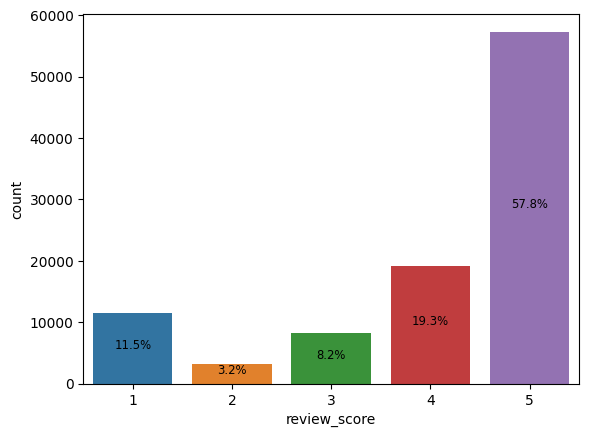

In [5]:
countplot2(reviews,'review_score')

Percebe-se que a maior parte (57,8%) dos pedidos têm avaliação de 5 estrelas, e a frequência é cada vez menor até chegar às 2 estrelas. Para 1 estrela verifica-se uma maior ocorrência, cerca de 11,5% dos pedidos receberam essa avaliação.

Por mais que os valores intermediários possam ser interpretados de diferentes maneiras, uma avaliação de 1 estrela possivelmente significa o fim do relacionamento com o cliente, enquanto uma avaliação de 5 estrelas pode ser um indicativo de que possivelmente o cliente irá comprar novamente no futuro.

Um ponto interessante para entender os reviews é analisar "manualmente" avaliaçoes escritas de pedidos com diferentes avaliações. Para essa análise, será criado um dataframe unindo as tabelas de pedidos, itens dos pedidos, reviews dos pedidos, clientes, geolocalização dos clientes, produtos e vendedores.

A feature *order_status* da tabela *orders* informa o status dos pedidos disponíveis no dataset. Iremos, na maior parte das análise, desconsiderar os pedidos que não foram entregues (menos de 3% do dataset).

In [6]:
orders['order_status'].value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

In [7]:
aux_df = reviews.loc[~(reviews['review_comment_message'].isna())&(reviews['review_comment_message'] != '')]
aux_df = aux_df.sample(frac=1)
for i in range(5):
    print('Comentários nota',i+1)
    for comment in aux_df.loc[aux_df['review_score'] == i+1]['review_comment_message'].iloc[:8].values:
        print('-',' '.join(comment.split('\n')))
    print('\n')

Comentários nota 1
- Sempre comprei nas Lojas lannister pela entrega ser rápida e desta vez nem recebi a mercadoria. Gostaria que tomassem uma atitude a respeito deste parceiro, para não denegrir a imagem das Lojas Ameri
 
- Veio a fonte e quatro emissores mas o aparelho transmissor não veio 
 Quando utilizo o cartucho 664xl original , ele dura em média o dobro.
 Recebi apenas 1 cartucho
- Recebi o produto com a base fixa da cadeira diferente da que esta no anuncio, só não devolvi a cadeira porque preciso com urgência. Não recomendo!
- A capa veio danificada. Colada. Já abri reclamação e aguardo o reembolso do meu dinheiro.
- comprei 5 kg de bicarbonato, mas foram entregues somente 3 pacotes de 1kg.


Comentários nota 2
- Produto se diz grande mas não cabe na criança !
- Bom
- No anuncio diz outra cor
- Só recebi a capa protetora, o lençol branco não chegou. Além disso a capa protetora não atendeu as minhas expectativas.
- prazo longo demais e ainda não chegou.....
- Entregue dentro do

Percebe-se, até certo ponto, que **atrasos**, **quantidades erradas** e **itens errados** são fatores relacionados com avaliações ruins. Vale notar que, a partir dos dados disponíveis, não conseguimos extrair informações sobre a quantidade e os produtos enviados, ainda que essas sejam reclamações constantes em pedidos mal avaliados.

Por outro lado, **entrega antes do prazo**, **boa qualidade do produto** e **boa embalagem** estão relacionados com avaliações boas.

### 3.1 Análise da relação atraso-avaliação 

Com os dados que possuímos, podemos fazer uma análise sobre a relação entre a ocorrência de atraso e a avaliação e também investigar, até certo ponto, se a causa do atraso pode ter sido a demora do cliente da Olist em postar o produto para que se prosseguisse com a entrega.

Para a análise, será criado um dataframe unindo as tabelas de pedidos e reviews dos pedidos, e as datas serão transformadas de strings para o formato datetime. Serão criadas, então, duas features:

- *delivery_delay*: indica o atraso em dias na entrega
- *delayed*: indica a ocorrência de atraso

In [8]:
ra_df = orders.merge(reviews,on='order_id')
ra_df = ra_df.loc[ra_df['order_status'] == 'delivered']
ra_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [9]:
ra_df = orders.merge(reviews,on='order_id')
date_columns = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
                'order_estimated_delivery_date']

for col in date_columns:
    ra_df[col] = pd.to_datetime(ra_df[col])

In [10]:
ra_df['delivery_delay'] = (ra_df['order_delivered_customer_date'] - ra_df['order_estimated_delivery_date']).dt.floor('d').dt.days
ra_df['delayed'] = ra_df['delivery_delay'].apply(lambda x: 'ATRASADO' if x > 0 else 'NAO ATRASADO')

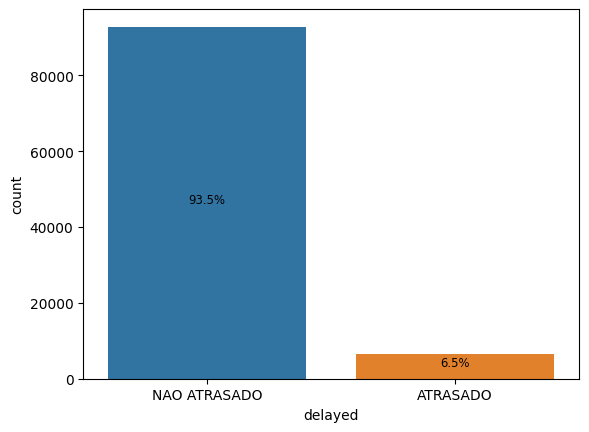

In [11]:
countplot2(ra_df,'delayed',cat=True)

count    96359.000000
mean       -11.917797
std         10.114024
min       -147.000000
25%        -17.000000
50%        -12.000000
75%         -7.000000
max        188.000000
Name: delivery_delay, dtype: float64

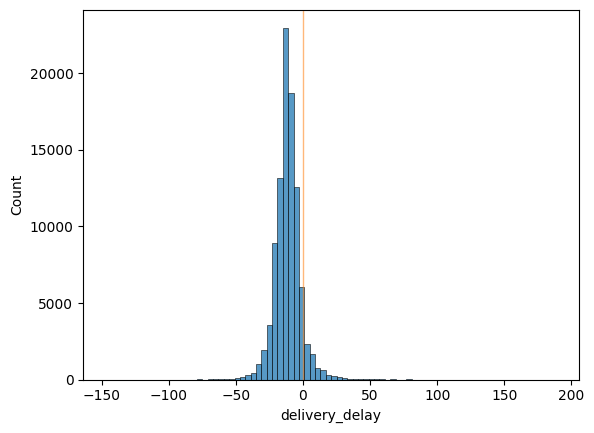

In [12]:
countplot2(ra_df,'delivery_delay',hist=True,binwidth=4,annot=False)
plt.axvline(x=0,color='tab:orange',linewidth=1,alpha=0.55)
ra_df['delivery_delay'].describe()

Apenas 6,5% dos pedidos sofreram atraso na entrega, e, em média, os pedidos são entregues cerca de 12 dias antes do prazo informado ao cliente no ato da compra.

Utilizando a feature *delayed*, iremos avaliar a distribuição de notas entre os pedidos entregues no prazo e os pedidos atrasados.

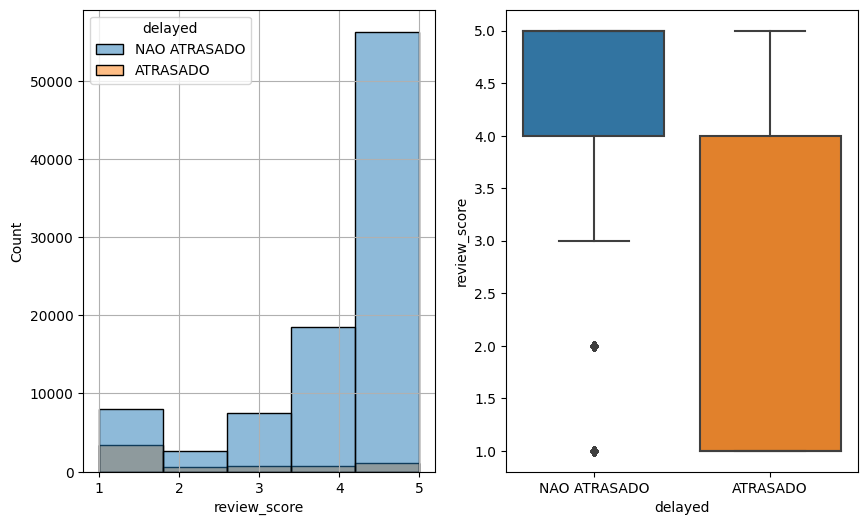

In [46]:
kde_1d(ra_df,'review_score','delayed',discrete=True,binwidth=0.8)

Nota-se que a avaliação média dos pedidos entregues com atraso é consideravelmente menor do que a dos produtos entregues no prazo. Percebe-se, também um aumento da proporção de pedidos atrasados conforme se diminui a nota da avaliação. Isso será melhor visualizado abaixo.

,5,4,1,3,2
total,0.577763,0.192917,0.115133,0.08243,0.031756


,review_score 1,review_score 2,review_score 3,review_score 4,review_score 5
ATRASADO,0.301471,0.176452,0.085341,0.034061,0.01849
NAO ATRASADO,0.698529,0.823548,0.914659,0.965939,0.98151


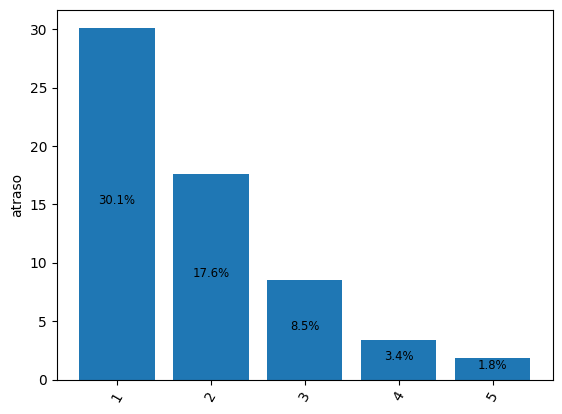

In [14]:
bar_plot(ra_df.sort_values(by='review_score'),'review_score','delayed',"ATRASADO",'atraso')

A hipótese levantada anteriormente se confirma, há um aumento significativo da proporção de entregas atrasadas conforme a nota da avaliação diminui.

#### 3.1.1. Análise da causa do atraso

No modelo logístico proposto pela Olist, o estoque é responsabilidade do vendedor, que deve encaminhar o produto a Olist para que a entrega seja feita. Portanto, é possível que um atraso no encaminhamento do produto à Olist resulte em um atraso na entrega para o consumidor final. Diante disso, é importante avaliar a proporção de entregas atrasadas por conta de atrasos no encaminhamento e, posteriormente, verificar se alguns clientes em específico possuem taxas maiores de atraso.

Para essa análise será criado um dataframe unindo o dataframe criado anteriormente e a tabela *order_items*, comparando a data limite para encaminhamento e data em que o encaminhamento ocorreu.

In [16]:
dc_df = ra_df.merge(items,on='order_id')
dc_df['shipping_limit_date'] = pd.to_datetime(dc_df['shipping_limit_date'])
dc_gb_df = pd.pivot_table(dc_df[['order_id','shipping_limit_date','order_delivered_carrier_date','delivery_delay','delayed']],index='order_id',aggfunc=['max'])
cols = []
for col in dc_gb_df.columns:
    cols.append(col[1])
dc_gb_df.columns = cols
dc_gb_df['delivery_delayed'] = dc_gb_df['delayed'].apply(lambda x: x == 'ATRASADO')
dc_gb_df['shipping_delay'] = dc_gb_df['order_delivered_carrier_date'] - dc_gb_df['shipping_limit_date'] 
dc_gb_df['shipping_delayed'] = dc_gb_df['shipping_delay'].apply(lambda x: x.total_seconds() > 0)

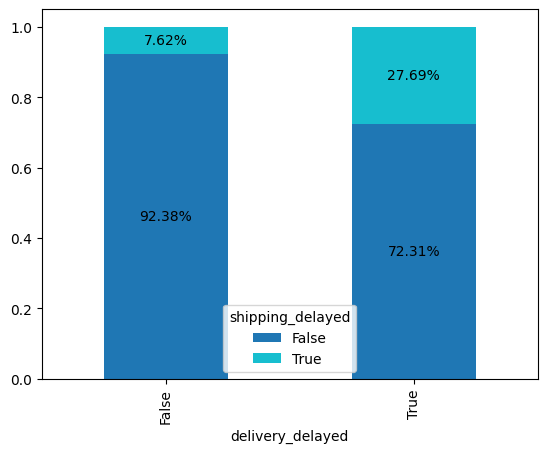

In [17]:
stacked_plot(dc_gb_df,'shipping_delayed','delivery_delayed',loc='lower center')

In [18]:
dc_gb_df[['shipping_delayed','delivery_delayed']].corr()

,shipping_delayed,delivery_delayed
shipping_delayed,1.000000,0.173787
delivery_delayed,0.173787,1.000000


Verifica-se que a proporção de atrasos no encaminho é consideravelmente maior nos pedidos que foram entregues com atraso ao consumidor final, de modo que existe uma correlação de 0.174, que pode ser considerada pequena, entre o atraso na entrega e o atraso no encaminhamento. 

Assim, pode-se considerar que garantir que o encaminhamento seja feito dentro do prazo estipulado pode reduzir a taxa de atrasos na entrega, porém os parceiros logísticos da Olist e o processo no geral também podem ser reavaliados para garantir uma menor ocorrência de atrasos.

### 3.2 Análise das categorias de produtos

Nesta seção será analisada a relação entre as diferentes categorias de produtos e a avaliação dos clientes.

Para isso, será criado um dataframe que resume as as diferentes categorias de produtos em categorias agregadas e algumas métricas. Vale notar que, para efeitos de análise, serão desconsiderados pedidos compostos por 2 ou mais produtos diferentes, uma vez que não é possível avaliar a qual item do pedido a avaliação se refere.


In [19]:
len(products['product_category_name'].unique())

74

Originalmente, o dataset conta com 74 categorias de produtos. Para facilitar a análise, essas categorias serão resumidas em 9.

In [21]:
pa_df = items.merge(orders,on='order_id')
pa_df = pa_df.merge(products,on='product_id')
pa_df = pa_df.merge(reviews,on='order_id')

aux_df = pd.pivot_table(pa_df,index='order_id',aggfunc={'product_id': 'count'})
valid_index = aux_df.loc[aux_df['product_id'] == 1].index

pa_df = pa_df.dropna(subset='product_category_name')
pa_df = pa_df.loc[pa_df['order_id'].isin(valid_index)]

In [24]:
cats = products['product_category_name'].unique()

agg_kw = {'casa': ['cama','mesa','banho','casa','domest','moveis','jardim','cozinha','construção'],
           'farmacia_beleza': ['perfum','bebes','higie','frald','belez'],
           'vestuario': ['fashion','roupa','relog'],
           'comida': ['alim'],
           'tech': ['inform','eletr','telef','foto','games','pc','dvd','tablet','climat'],
           'livros': ['livro'],
            'lazer': ['music','artes','flor','brinq','lazer'],
          'utilidades': ['ferram','papel','auto','pet']}

agg_dict = {}

for cat in cats:
    if not(pd.isna(cat)):
        flag = True
        for key in agg_kw.keys():
            if flag:
                for kw in agg_kw[key]:
                    if kw in cat:
                        agg_dict[cat] = key
                        flag = False
                        break
        if flag:
            agg_dict[cat] = 'other'

pa_df['product_dept'] = pa_df['product_category_name'].map(agg_dict)

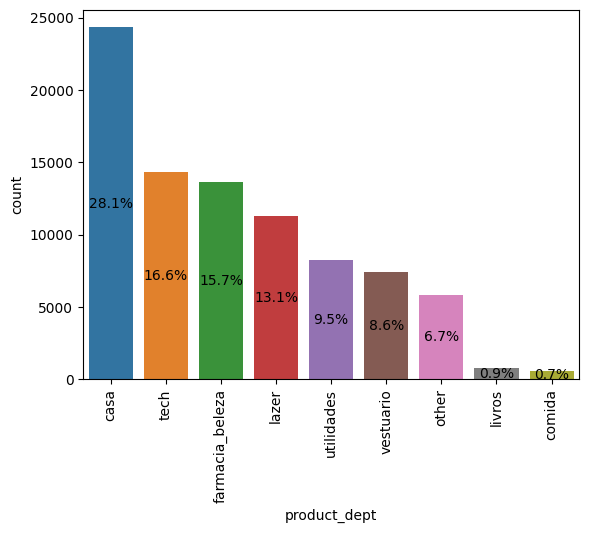

In [25]:
target(pa_df,'product_dept',rotation=90)

Verifica-se que a categoria mais comum é a de itens para casa (28,1%), seguida do setor de tecnologia (16,6%) e do setor de farmácia e beleza (15,7%).

Para avaliar as diferenças entre as categorias, serão utilizadas calculadas algumas métricas relacionadas com preço médio, avaliação, etc.

In [26]:
pa_df['delivery_delay'] = (pa_df['order_delivered_customer_date'] - pa_df['order_estimated_delivery_date']).dt.floor('d').dt.days
pa_df['delayed'] = pa_df['delivery_delay'].apply(lambda x: x > 0)

In [27]:
aggfunc = {'order_id': ['count',lambda x: len(x.unique())],
           'delayed': 'sum',
           'review_score': ['mean','min','max',np.std],
           'price': ['mean','min','max',np.std,'sum']
    
}

aggfunc_names = ['total_delayed','total_unique_orders','total_items','max_price','avg_price',
                 'min_price','std_price','total_revenue','max_review_score','mean_review_score',
                 'min_review_score','stdev_review_score']

pa_gb_df = pd.pivot_table(pa_df,index='product_dept',aggfunc=aggfunc)
pa_gb_df.columns = aggfunc_names
pa_gb_df = pa_gb_df.reset_index()

In [28]:
pa_gb_df['delay_rate'] = pa_gb_df['total_delayed']/pa_gb_df['total_items']
pa_gb_df['sales_qty_rate'] = pa_gb_df['total_items']/sum(pa_gb_df['total_items'])
pa_gb_df['revenue_rate'] = pa_gb_df['total_revenue']/sum(pa_gb_df['total_revenue'])

A tabela abaixo apresenta algumas métricas sobre as categorias agregadas e está ordenada do setor de maior receita para o setor de menor receita.

In [29]:
pa_gb_df.sort_values(by='revenue_rate',ascending=False)[['product_dept','sales_qty_rate','revenue_rate','avg_price','mean_review_score','delay_rate']]


,product_dept,sales_qty_rate,revenue_rate,avg_price,mean_review_score,delay_rate
0,casa,0.281322,0.249914,115.856844,4.123628,0.067938
2,farmacia_beleza,0.157478,0.165474,137.038963,4.195595,0.073568
6,tech,0.166000,0.149163,117.189393,4.100439,0.064846
3,lazer,0.130827,0.132372,131.957262,4.222713,0.064693
8,vestuario,0.086035,0.115609,175.246299,4.134256,0.067195
7,utilidades,0.095308,0.096726,132.357019,4.205022,0.064904
5,other,0.067385,0.081877,158.465173,4.212766,0.057824
4,livros,0.008799,0.005602,83.037884,4.463863,0.068331
1,comida,0.006845,0.003262,62.148277,4.332770,0.059122


O setor de *casa* representa cerca de 1/4 da receita total no dataset analisado e apresenta a segunda pior média de avaliações entre as categorias avalidas. 

O setor de *farmácia e beleza*, responsável por aproximadamente 16,5% da receita, possui uma avaliação média abaixo da média e a maior taxa de atrasos em entregas.

O setor de *tech*, com quase 15% da receita, possui a pior média de avaliação de todas.

Vale notar, também, que os setores de livros e comida apresentam as duas maiores média de avaliação, ainda que não representem, somadas, nem 1% da receita total.

Em resumo, as 3 categorias mais "importantes" somadas representam mais de 50% da receita total dentre os dados do dataset, tendo, as 3, avaliações médias abaixo da média de todo o dataset. Isso pode indicar, em tese, que esforços para melhorar a qualidade dos produtos desses setores, minimizar a taxa de atrasos e garantir um bom atendimento ao consumidor podem ter grande impacto na receita dos clientes e, por conseguinte, na receita da Olist.

## 4. Análise dos clientes

Neste passo da análise o foco será entender os clientes da Olist, ou seja, os empreendedores parceiros da Olist.

Para isso será criado um dataframe unindo as tabelas *orders*, *items*, *reviews*, *produtos* e *sellers*. Serão aproveitadas, ainda, as features criadas na análise anterior.

In [30]:
len(sellers['seller_id'].unique())

3095

O dataset conta com 3095 clientes.

Vale notar que os reviews estão atrelados ao pedido como um todo, e não a cada um dos itens comprados. Dessa forma, caso um pedido tenha mais de um vendedor atrelado não será fácil entender sobre qual produto a nota e o comentário da avaliação estão associados. Os pedidos com mais de um vendedor serão desconsiderados na análise.

In [33]:
sa_df = dc_df.merge(sellers,on='seller_id')
sa_df = sa_df.merge(dc_gb_df.reset_index()[['order_id','shipping_delay','shipping_delayed','delivery_delayed']],on='order_id')
sa_df = sa_df.merge(products,on='product_id')
aux_df = pd.pivot_table(sa_df,index='order_id',aggfunc={'seller_id': lambda x: len(x.unique())})
valid_index = aux_df.loc[aux_df['seller_id'] == 1].index

sa_df = sa_df.loc[sa_df['order_id'].isin(valid_index)]

Os dados serão agregados para cada vendedor, sendo criadas algumas métricas a partir do dataset completo. Posteriormente, as métricas serão agregadas à tabela de vendedores original para manter as informações específicas do vendedor, como sua localização.

In [34]:
aggfunc = {'price': ['sum','mean'], 
           'order_id': ['count',lambda x: len(x.unique())],
          'delivery_delayed': 'sum',
          'shipping_delayed': 'sum',
          'review_score': 'mean',
           'product_category_name': lambda x: list(x.value_counts().index),
           'order_purchase_timestamp': ['min','max']
          }

aggfunc_names = ['total_delivery_delayed','total_orders','total_items','last_order','first_order','avg_prod_price',
                'total_revenue','mcc','mean_review_score','total_shipping_delayed']
sa_gb_df = pd.pivot_table(sa_df,index='seller_id',aggfunc=aggfunc)
sa_gb_df.columns = aggfunc_names

In [35]:
last_order = sa_df['order_purchase_timestamp'].max()

sa_gb_df['delivery_delay_rate'] = sa_gb_df['total_delivery_delayed']/sa_gb_df['total_orders']
sa_gb_df['shipping_delay_rate'] = sa_gb_df['total_shipping_delayed']/sa_gb_df['total_orders']
sa_gb_df['mean_item_qty'] = sa_gb_df['total_items']/sa_gb_df['total_orders']
sa_gb_df['avg_ticket'] = sa_gb_df['total_revenue']/sa_gb_df['total_orders']
sa_gb_df['most_common_category'] = sa_gb_df['mcc'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
sa_gb_df['first_order_age'] = last_order - sa_gb_df['first_order']
sa_gb_df['last_order_age'] = last_order - sa_gb_df['last_order']
sa_gb_df['partner_age'] = sa_gb_df['last_order'] - sa_gb_df['first_order']
sa_gb_df['order_freq'] = sa_gb_df['total_orders']/sa_gb_df['partner_age'].dt.days

### 4.1. Análise de quantidade de pedidos e receita

Um ponto interessante é analisar a distribuição da quantidade de pedidos e da receita entre os clientes.

In [36]:
sa_gb_df[['total_revenue','total_orders']].describe()

,total_revenue,total_orders
count,3073.000000,3073.000000
mean,4313.712581,31.452327
std,13685.548952,102.351215
min,3.500000,1.000000
25%,208.350000,2.000000
50%,810.000000,6.000000
75%,3248.800000,21.000000
max,225406.850000,1807.000000


Mais da metade dos clientes fizeram 6 vendas ou menos, enquanto apenas 25% deles fizeram mais do que 20 vendas pela plataforma. 

Olhando para a receita, apenas 50% venderam mais do que 715 reais em produtos, enquanto apenas 25% tiveram uma receita acima dos 2814 reais.

In [41]:
max_rev = sa_gb_df.sort_values(by='total_revenue',ascending=False)['total_revenue'].iloc[0]
total_rev = sum(sa_gb_df['total_revenue'])
print('O maior cliente representa {:.1f}% da receita total. Receita do maior cliente: R${:.2f}'.format(max_rev/total_rev*100,max_rev))
for i in [10,20,50,100,129]:
    aux_df = sa_gb_df.sort_values(by='total_revenue',ascending=False)['total_revenue'].iloc[:i]
    
    print('Os {} maiores clientes representam {:.1f}% da receita total. Receita média: R${:.2f}'.format(i,(aux_df.cumsum()/sum(sa_gb_df['total_revenue']))[:i][-1]*100,sa_gb_df.sort_values(by='total_revenue',ascending=False)['total_revenue'].iloc[:i].mean()))

O maior cliente representa 1.7% da receita total. Receita do maior cliente: R$225406.85
Os 10 maiores clientes representam 13.2% da receita total. Receita média: R$175078.17
Os 20 maiores clientes representam 21.2% da receita total. Receita média: R$140484.99
Os 50 maiores clientes representam 33.1% da receita total. Receita média: R$87681.55
Os 100 maiores clientes representam 45.3% da receita total. Receita média: R$59995.20
Os 129 maiores clientes representam 50.1% da receita total. Receita média: R$51469.97


É interessante ter em mente que apenas 129 clientes, cerca de 4% do total de clientes do dataset, representam metade da receita total da Olist (dentro do dataset). A perda de um dos 125 maiores clientes é, de certo modo, equivalente a perda de cerca de 12 clientes médios. Quando se olha para os 10 maiores, uma única perda representa mais de 1% da receita total, sendo equivalente a quase 40 clientes médios.

Isso representa, de certa forma, uma face do risco de negócio da Olist. Caso um ou mais clientes grandes desejem focar em canais de vendas próprios ou decidam firmar parceria com concorrentes da Olist, as perdas podem representar um risco à integridade do negócio. Aumentar a receita média da base de clientes e, de certo modo, minimizar sua variância, sempre com o objetivo de aumentar a receita gerada, podem ser estratégias interessantes para minimizar os efeitos da perda de um grande cliente.

### 4.2. Análise de avaliações

### 4.3. Análise da taxa de atrasos 

## 5. Segmentação geral dos consumidores

## 6. Segmentação dos consumidores nos maiores clientes

## 7. Análise de retenção de clientes

## 8. Conclusão